In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [9]:
img = cv2.imread("test2.jpg")

In [10]:
# ---------------------- 1. DENOISING (PRE-PROCESSING) ---------------------- #
# Noise reduction using Non-Local Means
denoised_img = cv2.fastNlMeansDenoisingColored(img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

In [11]:
# ---------------------- 2. THRESHOLDING ---------------------- #
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
denoised_gray = cv2.cvtColor(denoised_img, cv2.COLOR_BGR2GRAY)

# Apply median blur to reduce noise
blurred = cv2.medianBlur(gray, 5)
blurred_denoised = cv2.medianBlur(denoised_gray, 5)

# Thresholding methods
_, th_binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
th_adaptive_mean = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 7, 2)
th_adaptive_gaussian = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

In [12]:
# ---------------------- 3. CONTOUR DETECTION ---------------------- #
# Sobel Gradient
grad_X = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=-1)
grad_Y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=-1)
gradient_combined = cv2.addWeighted(cv2.convertScaleAbs(grad_X), 0.5, cv2.convertScaleAbs(grad_Y), 0.5, 0)

# Binarization
_, threshold_binary = cv2.threshold(gradient_combined, 100, 255, cv2.THRESH_BINARY_INV)

In [13]:
# ---------------------- 4. SKETCH EFFECT ---------------------- #
# Edge sharpening
kernel_sharpening = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened = cv2.filter2D(img, -1, kernel_sharpening)

# Convert to grayscale
adjusted_gray = cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY)
dark_mask = adjusted_gray < 50
adjusted_gray[dark_mask] = np.clip(adjusted_gray[dark_mask] + 50, 0, 255)

# Sketch effect
inv = 255 - adjusted_gray
gaussgray = cv2.GaussianBlur(inv, ksize=(15, 15), sigmaX=0, sigmaY=0)

def dodgeV2(image, mask):
    return cv2.divide(image, 255 - mask, scale=256)

pencil_sketch = dodgeV2(adjusted_gray, gaussgray)

# Final noise reduction
denoised_pencil_sketch = cv2.bilateralFilter(pencil_sketch, d=5, sigmaColor=75, sigmaSpace=75)

gamma = 2
denoised_pencil_sketch_clear = np.array(255 * (denoised_pencil_sketch / 255) ** gamma, dtype=np.uint8)

## Résultats:

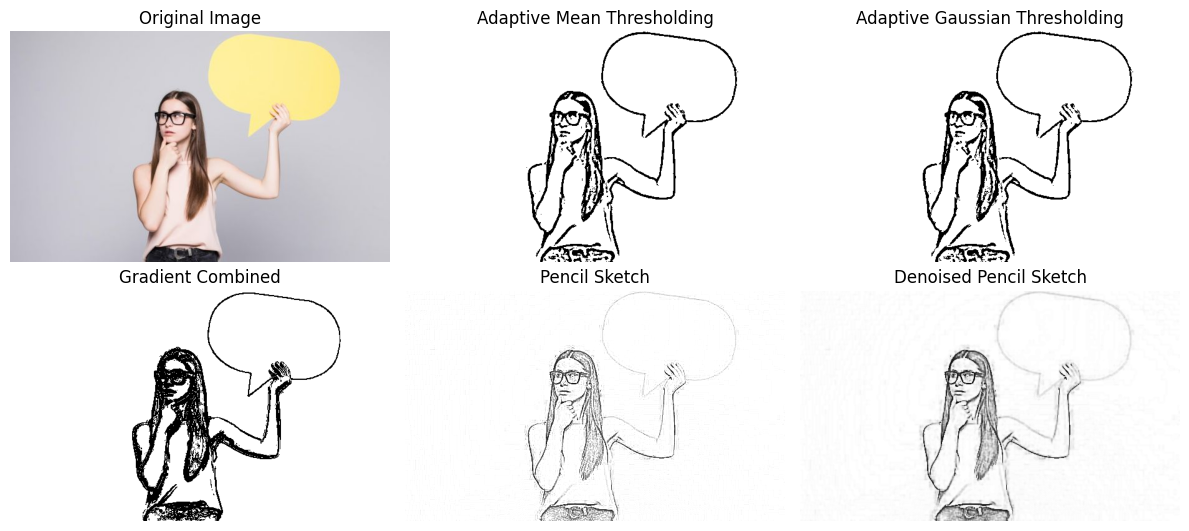

In [14]:
# Results to compare
titles = [
    "Original Image", "Adaptive Mean Thresholding", 
    "Adaptive Gaussian Thresholding", "Gradient Combined",
    "Pencil Sketch", "Denoised Pencil Sketch"
]
images = [
    img, th_adaptive_mean,
    th_adaptive_gaussian, threshold_binary,
    pencil_sketch, denoised_pencil_sketch_clear
]

# Display results
plt.figure(figsize=(12, 8))
for i in range(len(images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) if len(images[i].shape) == 3 else images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
cv2.imwrite('denoised_pencil_sketch.jpg', denoised_pencil_sketch)
cv2.imwrite('denoised_pencil_sketch_clear.jpg', denoised_pencil_sketch_clear)

True